In [40]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import pandas as pd
import pandas_datareader as web
import datetime as dt
import requests
import json
from datetime import datetime as dt
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

token = 'pk_f3c298b912074db48d958ae988683ff6'

sym = 'AAPL'
prev1y='https://cloud.iexapis.com/stable/stock/'+sym+'/chart/1y?token='+token+''
r1d= requests.get(prev1y)
prev1y=json.loads(r1d.text)
df= pd.DataFrame(prev1y)

data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)


dataset = new_data.values

training_data_len = math.ceil( len(dataset) *.8) 


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:training_data_len  , : ]

x_train, y_train = [], []
for i in range(60,len(train_data)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

test_data = scaled_data[training_data_len - 60: , : ]

X_test = []
y_test = dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

rmse=np.sqrt(np.mean(((closing_price- y_test)**2)))
rmse

143/143 - 3s - loss: 0.0055


10.718377353535942

In [41]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['closing_price'] = closing_price

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


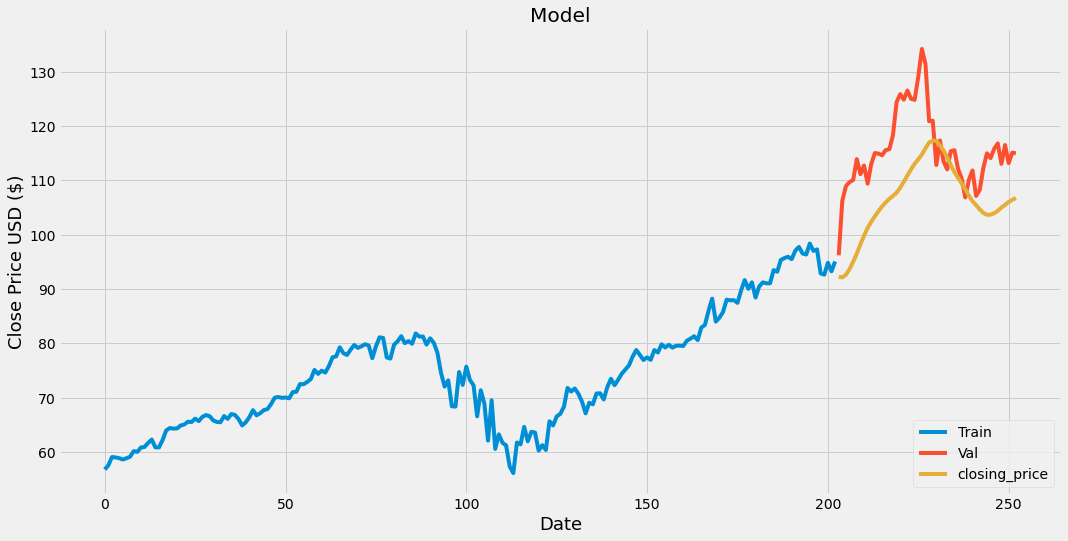

In [42]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'closing_price']])
plt.legend(['Train', 'Val', 'closing_price'], loc='lower right')
plt.show()